Import libraries

In [110]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Useful adjusts

In [111]:
# Show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Exibition format for float numbers to not use scientific notation and show as a integer number (0 decimal places)
pd.options.display.float_format = lambda x: f'{x:.2f}'

Import database from SQL

In [112]:
# --- 1. Database information ---
server_name = 'THIAGOCOMPUTADO'
database_name = 'Project_global_economy_indicators'
#table_name = 'main_dataset'
schema_name = 'dbo'

# --- 2. Creating conection string ---
connection_string = (f"mssql+pyodbc://{server_name}/{database_name}?""driver=ODBC+Driver+17+for+SQL+Server&""Trusted_Connection=yes")

# --- 3. Creating engine and data import ---
engine = create_engine(connection_string)

query = '''

SELECT
    md.*, -- Todas as colunas da main_dataset
    cd.Continent -- Apenas a coluna Continent da countries_details
FROM
    dbo.main_dataset AS md
JOIN
    dbo.countries_details AS cd ON md.[ CountryID ] = cd.[CountryID];

'''

df = pd.read_sql(query, engine)

#print(df.columns)

Análise de Indicadores Econômicos e Sociais
Este resumo detalha os principais indicadores utilizados para analisar a situação econômica e social de um país.

1. Identificação Básica
Country (País): Nome da nação.
Year (Ano): Ano de referência dos dados.
Population (População): Número total de habitantes.
Currency (Moeda): Unidade monetária oficial (ex: BRL, USD).

2. Indicadores Macroeconômicos Agregados
Gross Domestic Product (GDP) / PIB: Valor total de todos os bens e serviços finais produzidos dentro do território de um país em um ano. Mede a atividade econômica interna.
Gross National Income (GNI) / RNB: Renda total dos residentes de um país. É calculado como PIB + renda líquida vinda do exterior. Mede o poder de compra da nação.
Per Capita GNI (RNB per capita): A Renda Nacional Bruta dividida pela população. É um indicador do padrão de vida médio por pessoa.

3. Componentes do PIB (Pela Ótica da Despesa)
Mostra como a produção do país é gasta. A fórmula é: PIB = C + G + I + (X - M).
Household Consumption (C): Gastos das famílias em bens e serviços.
Government Consumption (G): Gastos do governo (ex: salários de funcionários, saúde, educação).
Gross Capital Formation (I): Investimento total na economia, incluindo:
Gross Fixed Capital Formation: Compra de máquinas, equipamentos e construções.
Changes in Inventories: Variação nos estoques das empresas.
Exports (X): Vendas de bens e serviços para o exterior.
Imports (M): Compras de bens e serviços do exterior.

4. Componentes do PIB (Pela Ótica da Produção)
Mostra a contribuição de cada setor para a economia, medida pelo Valor Adicionado (valor da produção menos o custo dos insumos).
Agriculture, etc. (ISIC A-B): Setor primário.
Mining, Manufacturing, Utilities (ISIC C-E): Setor secundário (indústria).
Construction (ISIC F): Construção civil.
Trade and Services (ISIC G-P): Setor terciário, incluindo comércio, transporte, finanças, saúde, educação e outros serviços.

5. Indicadores Monetários
Exchange Rate (Taxa de Câmbio): Valor da moeda local em relação a uma moeda estrangeira (geralmente o dólar). É essencial para comparações internacionais.
IMF: Taxa registrada pelo Fundo Monetário Internacional.
AMA: Provavelmente "Annual Moving Average" (Média Móvel Anual), que suaviza as flutuações diárias.

Engine features

In [113]:
# ============================================================================================================================================================
# STEP 1: Structure cleaning
# objective: Dataframe preparing, removing unproductive and standardizing columns to facilitate analysis.
# ============================================================================================================================================================

# 1.0 --- Removing whitespace from entire dataframe
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# 1.1 --- Rename columns to easy mode
new_columns = ['countryid', 'country', 'year', 'exchange rate ama', 'exchange rate imf', 'population', 'currency', 'per capita',
               'agriculture, hunting, forestry, fishing', 'changes in inventories', 'construction', 'exports of goods and services', 'final consumption expenditure',
               'general government final consumption expenditure', 'gross capital formation', 'gross fixed capital formation',
               'household consumption expenditure', 'imports of goods and services', 'manufacturing',
               'mining, manufacturing, utilities', 'other activities', 'total value added', 'transport, storage and communication',
               'Trade and Services ', 'gross national income in usd', 'gross domestic product','Continent']
df.columns = new_columns

df.loc[df['country'] == 'TÃ¼rkiye', 'country'] = 'Türkiye'
df.loc[df['country'] == 'Türkiye','Continent'] = 'Asia'

# 1.2 --- Remove the column 'countryid' and 'currency' because both are useless in the analysis
df.drop(columns=['countryid','currency'], inplace=True)

# 1.3 --- Remove the column 'manufacturing' for critical data quality.
# Obs - The investigation revealed zero data for China for more than 30 years, making the column unreliable.
df.drop(columns=['manufacturing'], inplace=True)

# 1.4 --- Removes historical entities (Former) to ensure temporal consistency in the analysis.
df = df[~df['country'].str.contains(r"\(Former\)", na=False)].copy()


# ============================================================================================================================================================
# STEP 2: CONTENT AND TYPE TREATMENT
# Objective: Clean cells, converting types and handling missing (null) values ​​analytically.
# ============================================================================================================================================================

# 2.0 --- Initial conversion for number
# Converts columns to numeric type, forcing text erros to become null (Nan)
df['changes in inventories'] = pd.to_numeric(df['changes in inventories'], errors='coerce')


# 2.1 --- Imputation of Nulls (Filling in Missing Values)

# Strategy A: Contextual Fill with Zero
# Obs: For countries where agriculture is insignificant (based on research), the null is filled with 0.
country_to_zero = ['Monaco', 'Sint Maarten (Dutch part)', 'China, Macao SAR']
df.loc[df['country'].isin(country_to_zero), 'agriculture, hunting, forestry, fishing'] = 0

# Obs - For North Korea, missing data is assumed to be 0 due to the country's extreme isolation.
north_korea_index = df[df['country'] == 'D.P.R. of Korea'].index
df.loc[north_korea_index] = df.loc[north_korea_index].fillna(0)


# Strategy B: Filling with the Median
# Obs: The median is used because it is resistant to outliers, which are common in economic data.
df['changes in inventories'] = df['changes in inventories'].fillna(df['changes in inventories'].median())


# 2.2 --- Final conversion of types
# Obs - After all nulls are treatment, convert key columns for the integer type.
list_int = ['year','population']
df[list_int] = df[list_int].astype(int)


# ============================================================================================================================================================
# STEP 3: FINAL VALIDATION
# Objective: Ensure the cleaning process was successful.
# ============================================================================================================================================================
print('\n--- Final validation of cleaning process ---\n')
print(f'Total value of null: {df.isnull().sum().sum()}\n')

df.info()

df.head()


--- Final validation of cleaning process ---

Total value of null: 0

<class 'pandas.core.frame.DataFrame'>
Index: 10342 entries, 0 to 10511
Data columns (total 24 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   country                                           10342 non-null  object 
 1   year                                              10342 non-null  int64  
 2   exchange rate ama                                 10342 non-null  float64
 3   exchange rate imf                                 10342 non-null  float64
 4   population                                        10342 non-null  int64  
 5   per capita                                        10342 non-null  float64
 6   agriculture, hunting, forestry, fishing           10342 non-null  float64
 7   changes in inventories                            10342 non-null  float64
 8   construction                  

,country,year,exchange rate ama,exchange rate imf,population,per capita,"agriculture, hunting, forestry, fishing",changes in inventories,construction,exports of goods and services,final consumption expenditure,general government final consumption expenditure,gross capital formation,gross fixed capital formation,household consumption expenditure,imports of goods and services,"mining, manufacturing, utilities",other activities,total value added,"transport, storage and communication",Trade and Services,gross national income in usd,gross domestic product,Continent
0,Afghanistan,1970,44998427.00,44998427.00,10752971,164.00,869917407.00,66013121.00,46793902.00,165618722.00,1663221269.00,112126986.00,94611818.00,94611818.00,1551094283.00,195277226.00,376690811.00,127747843.00,1731454254.00,83917200.00,226387091.00,1766527525.00,1731435587.00,Asia
1,Afghanistan,1971,44998427.00,44998427.00,11015857,168.00,910828104.00,66013121.00,48994113.00,193580300.00,1796541240.00,121114833.00,99012350.00,99012350.00,1675426407.00,276296480.00,394401164.00,133754097.00,1812857077.00,87860382.00,237019196.00,1850121913.00,1812837521.00,Asia
2,Afghanistan,1972,44998427.00,44998427.00,11286753,149.00,827945340.00,66013121.00,44535223.00,227654380.00,1607159399.00,108347543.00,103456794.00,103456794.00,1498811856.00,290370350.00,358512865.00,121582672.00,1647917912.00,79864525.00,215477287.00,1683947905.00,1647900178.00,Asia
3,Afghanistan,1973,44998427.00,44998427.00,11575305,150.00,855486925.00,66013121.00,46018542.00,226913554.00,1617037233.00,109013455.00,121728433.00,121728433.00,1508023800.00,262962880.00,370445793.00,125630236.00,1702734673.00,82528885.00,222624293.00,1739998153.00,1702716294.00,Asia
4,Afghanistan,1974,44998427.00,44998427.00,11869879,177.00,1035913365.00,66013121.00,55721659.00,284938449.00,1907408182.00,128588961.00,175061875.00,175061875.00,1778819221.00,305679151.00,448552790.00,152119162.00,2061751510.00,99918604.00,269525910.00,2106420227.00,2061729287.00,Asia


Exploratory Data Analysis (EDA)

Business Question #1: Prosperous Country Profile (Per capita)

In [114]:
recent_year = df['year'].max()
df_recent = df[df['year'] == recent_year]
top_10_prosperous = df_recent.sort_values(by= 'per capita', ascending= False).head(10)
print(f"🏆 Top 10 Most Prosperous Countries in {recent_year} (per capita):\n")
print(top_10_prosperous[['country','per capita','population']])

print("\n💭 Analysis of the 2021 ranking reveals a clear pattern of increased prosperity. :\n" \
"Prosperity, as measured by gross national income (GNI), is largely concentrated in small, sparsely populated countries. In addition, they are tied to models linked to the banking market.,\n" \
"aimed at large fortunes, heavily driven by tax benefits. Resulting in an exorbitant national income, divided by an often irrelevant denominator")

🏆 Top 10 Most Prosperous Countries in 2021 (per capita):

             country  per capita  population
6036          Monaco   234317.00       36686
5380   Liechtenstein   198294.00       39039
843          Bermuda   112607.00       64185
5464      Luxembourg    93369.00      639321
7061          Norway    93149.00     5403021
9183     Switzerland    90045.00     8691406
4420         Ireland    76726.00     4986526
2604         Denmark    70390.00     5854240
10144  United States    70081.00   336997624
4160         Iceland    69996.00      370335

💭 Analysis of the 2021 ranking reveals a clear pattern of increased prosperity. :
Prosperity, as measured by gross national income (GNI), is largely concentrated in small, sparsely populated countries. In addition, they are tied to models linked to the banking market.,
aimed at large fortunes, heavily driven by tax benefits. Resulting in an exorbitant national income, divided by an often irrelevant denominator


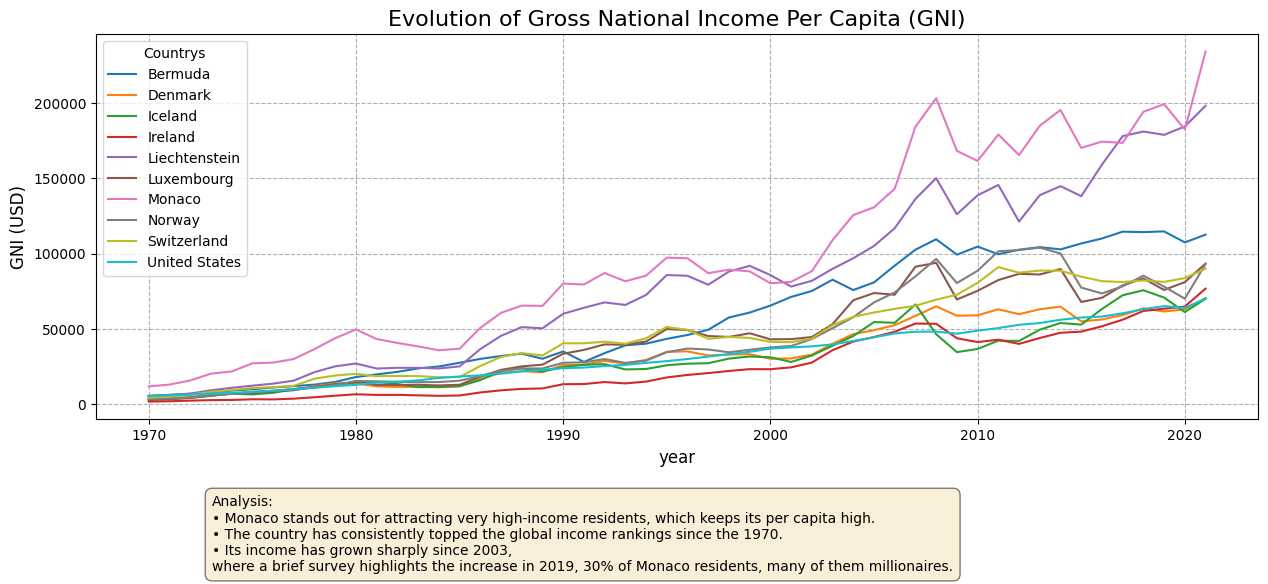

In [115]:
# --- STEP 1: Data filter ---
countrys = ['Monaco','Liechtenstein','Bermuda','Luxembourg','Norway','Switzerland','Ireland','Denmark','United States','Iceland']
df_evolution = df[df['country'].isin(countrys)]

# --- STEP 2: Create and customize the graphic ---
# Prepare the "window" with a good size.
plt.figure(figsize=(15, 5))
# Use Seaborn for draw the line graph.
sns.lineplot(
    data = df_evolution,
    x = 'year',
    y = 'per capita',
    hue = 'country',
)

# Use Matplotlib for add "storytelling"
plt.title('Evolution of Gross National Income Per Capita (GNI)', fontsize=16)
plt.xlabel('year', fontsize=12)
plt.ylabel('GNI (USD)', fontsize=12)
plt.grid(True, linestyle = '--')
plt.legend(title='Countrys')
plt.Text()

# --- CODE TO ADD TEXT BOX ---

comment = (
    "Analysis:\n"
    "• Monaco stands out for attracting very high-income residents, which keeps its per capita high.\n"
    "• The country has consistently topped the global income rankings since the 1970.\n"
    "• Its income has grown sharply since 2003,\n"
    "where a brief survey highlights the increase in 2019, 30% of Monaco residents, many of them millionaires."
)

# Add the text box to the chart 
plt.text(
    0.1,
   -0.3,
    comment,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='center',
    bbox=dict(
        boxstyle='round,pad=0.5',
        facecolor='wheat',
        alpha=0.5
    )
)


plt.show()

Business Question #2: Least Prosperous Country Profile (Per capita)

In [116]:
recent_year = df['year'].max()
df_recent = df[df['year'] == recent_year]

top_10_least_prosperous = df_recent.sort_values(by= 'per capita',ascending= True)

print(f"🔻 Top 10 Least Prosperous Countries in {recent_year} (by GNI per capita):\n")
print(top_10_least_prosperous[['country','per capita','population']].head(10))

print("\n💭 The analysis of the 2021 ranking reveals a clear pattern of lower prosperity:\n" \
"It is possible to see the large concentration of countries in the Sub-Saharan Africa region and regions with great climate instability and civil fragility linked to conflicts.\n" \
"While we see the greatest prosperity at the top of the global list related to the development of high-value services and a peaceful environment, we can observe the other side of the coin.\n" \
"The base of the list of least prosperity highlights the absence of these requirements, thus creating barriers that hinder, or even subject, them to a cycle of extreme poverty.")

🔻 Top 10 Least Prosperous Countries in 2021 (by GNI per capita):

                        country  per capita  population
10438                     Yemen      301.00    32981641
1447                    Burundi      312.00    12551213
51                  Afghanistan      377.00    40099462
8920                South Sudan      386.00    10748272
5276                    Liberia      413.00     5193416
8729                    Somalia      444.00    17065581
6308                 Mozambique      481.00    32077072
5568                 Madagascar      489.00    28915653
1791   Central African Republic      493.00     5457154
8509               Sierra Leone      499.00     8420641

💭 The analysis of the 2021 ranking reveals a clear pattern of lower prosperity:
It is possible to see the large concentration of countries in the Sub-Saharan Africa region and regions with great climate instability and civil fragility linked to conflicts.
While we see the greatest prosperity at the top of the global

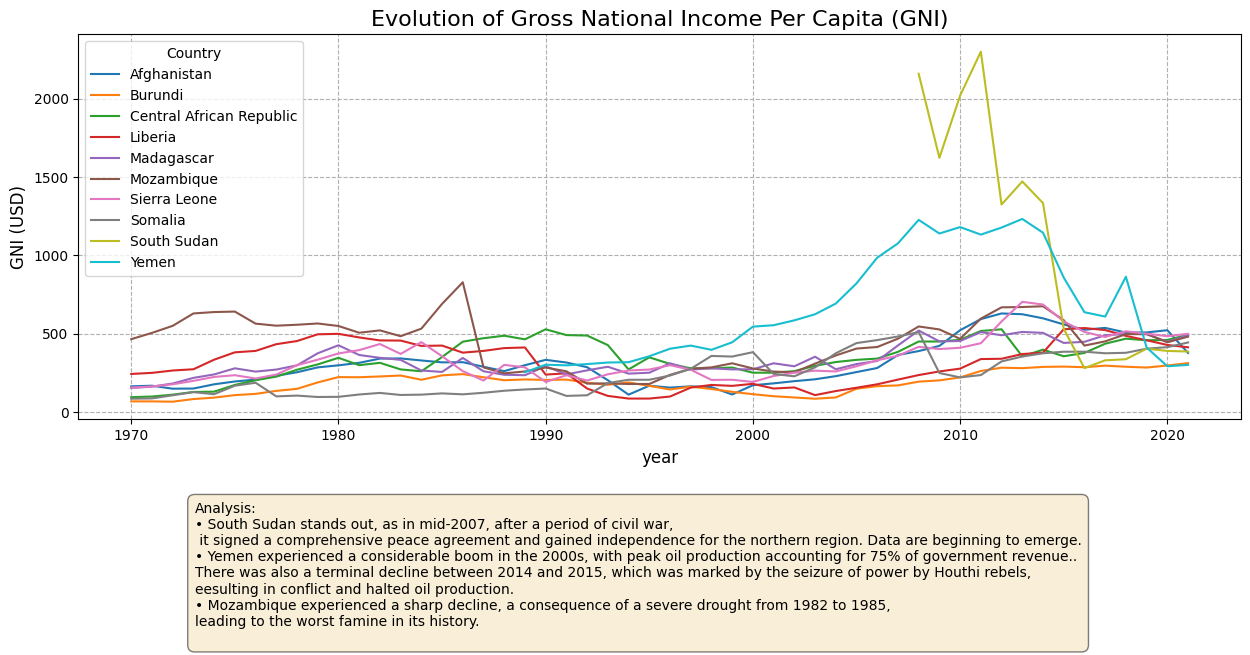

In [117]:
countrys = ['Yemen','Burundi','Afghanistan','South Sudan','Liberia','Somalia','Mozambique','Madagascar','Central African Republic','Sierra Leone']
df_evolution = df[df['country'].isin(countrys)]

plt.figure(figsize=(15,5))

sns.lineplot(
    data = df_evolution,
    x = 'year',
    y = 'per capita',
    hue = 'country'
)

plt.title('Evolution of Gross National Income Per Capita (GNI)', fontsize=16)
plt.xlabel('year', fontsize=12)
plt.ylabel('GNI (USD)', fontsize=12)
plt.grid(True, linestyle = '--')
plt.legend(title='Country')
plt.Text()

# --- CODE TO ADD TEXT BOX ---

comment = (
    "Analysis:\n"
    "• South Sudan stands out, as in mid-2007, after a period of civil war,\n"
    " it signed a comprehensive peace agreement and gained independence for the northern region. Data are beginning to emerge.\n"
    "• Yemen experienced a considerable boom in the 2000s, with peak oil production accounting for 75% of government revenue..\n"
    "There was also a terminal decline between 2014 and 2015, which was marked by the seizure of power by Houthi rebels,\n"
    "eesulting in conflict and halted oil production.\n"
    "• Mozambique experienced a sharp decline, a consequence of a severe drought from 1982 to 1985,\n"
    "leading to the worst famine in its history.\n"
)

# Add the text box to the chart 
plt.text(
    0.1,             
   -0.4,                 
    comment,              
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='center',  
    bbox=dict(               
        boxstyle='round,pad=0.5', 
        facecolor='wheat',    
        alpha=0.5       
    )
)

plt.show()

Prosperity Index

In [118]:
#Removing the population's weight from the indexes
df['pop_gross capital formation'] = df['gross capital formation'] / df['population']
df['pop_exports of goods and services'] = df['exports of goods and services'] / df['population']
df['pop_agriculture, hunting, forestry, fishing'] = df['agriculture, hunting, forestry, fishing'] / df['population']
df['pop_mining, manufacturing, utilities'] = df['mining, manufacturing, utilities'] / df['population']



Normalize_columns = ['per capita',
                           'pop_gross capital formation',
                           'pop_exports of goods and services',
                           'pop_agriculture, hunting, forestry, fishing',
                           'pop_mining, manufacturing, utilities']

# List to store the names of the new normalized columns
new_columns_norm = []
                 
# --- STEP 1: Loop to create ALL normalized columns ---
for col in Normalize_columns:
    min_val = df[col].min()
    max_val = df[col].max()

    name_norm = f'norm_{col}'

    df[name_norm] = (df[col] - min_val) / (max_val - min_val)
    
    new_columns_norm.append(name_norm)

df['prosperity_score'] = df[new_columns_norm].mean(axis=1)

recent_year = df['year'].max()
df_recent = df[df['year'] == recent_year]

top_10_score = df_recent.sort_values(by='prosperity_score', ascending=False).head(10)


# --- Final Ranking ---

# Dictionary with the columns we want to rank and their titles
rankings = {
    'prosperity_score': '🏆 Prosperity Index',
    'norm_per capita': '💰 Wealth (Per Capita Income)',
    'norm_pop_gross capital formation': '📈 Investment (Per Capita Capital)',
    'norm_pop_exports of goods and services': '🌍 Trade (Per Capita Exports)',
    'norm_pop_agriculture, hunting, forestry, fishing': '🌱 Agriculture/hunting, fishing (Per Capita Production)',
    'norm_pop_mining, manufacturing, utilities': '⛏️ Mining/manufacturing/utilities (Per Capita Production)'
}

# Loop to generate and print each Top 10
for index, title in rankings.items():
    top_10 = df_recent.sort_values(by=index, ascending=False).head(10)
    print(f"---{title}---\n")
    print(top_10[['country',index]])
    print("\n" + "-"*50 + "\n")

---🏆 Prosperity Index---

             country  prosperity_score
4420         Ireland              0.38
7061          Norway              0.29
10144  United States              0.29
5464      Luxembourg              0.28
9183     Switzerland              0.28
1999           China              0.25
6036          Monaco              0.20
447        Australia              0.18
9131          Sweden              0.17
5380   Liechtenstein              0.17

--------------------------------------------------

---💰 Wealth (Per Capita Income)---

             country  norm_per capita
6036          Monaco             1.00
5380   Liechtenstein             0.85
843          Bermuda             0.48
5464      Luxembourg             0.40
7061          Norway             0.40
9183     Switzerland             0.38
4420         Ireland             0.33
2604         Denmark             0.30
10144  United States             0.30
4160         Iceland             0.30

-------------------------------------

Correlação entre indicadores

In [119]:
# --- Análise de Correlação ---

# Seleciona as colunas mais relevantes para a análise de correlação
features_corr = [
    'per capita',
    'population',
    'exports of goods and services',
    'imports of goods and services',
    'agriculture, hunting, forestry, fishing',
    'gross capital formation',
    'prosperity_score' # Vamos incluir nosso índice para ver com o que ele se correlaciona!
]
df_corr = df[features_corr].copy()

# O método .corr() calcula a correlação entre todas as colunas numéricas do DataFrame
matriz_corr = df_corr.corr()

#print(matriz_corr)

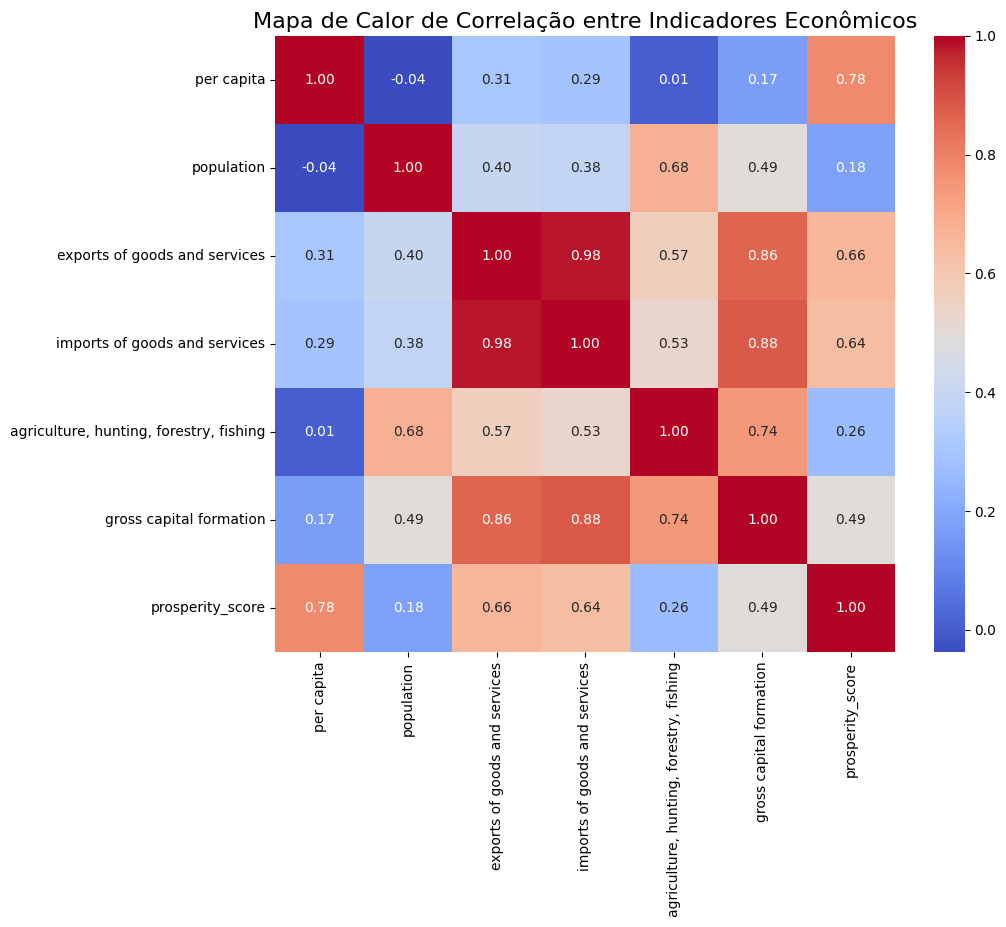

In [120]:
# Cria o mapa de calor (heatmap) com o Seaborn
plt.figure(figsize=(10, 8)) # Define um bom tamanho para a figura
sns.heatmap(
    matriz_corr,
    annot=True,      # Mostra os números (as anotações) dentro de cada célula
    cmap='coolwarm', # O esquema de cores: azul (frio) para negativo, vermelho (quente) para positivo
    fmt=".2f"        # Formata os números para terem apenas duas casas decimais
)
plt.title('Mapa de Calor de Correlação entre Indicadores Econômicos', fontsize=16)
plt.show()

population vs per : -0.04
The correlation between population size and per capita income confirmed our finding. The list of the richest countries includes Monaco and Liechtenstein, while the most populous countries, such as India, are not at the top. Being big doesn't mean being rich per capita.

exports vs imports : 0.98
This correlation means countries that exports a lot, import as well. They are open economys and integrated with global market.

gross capital formation vs. exports/imports : 0.86 / 0.88
Investments, exports and imports are strongly interlinked. This means these nations that are big players in the global market also are ones that invest the most in their own infrastructure and productive capacity.


Export dataframe to csv

In [121]:
print("--- VERIFICAÇÃO FINAL ANTES DE EXPORTAR ---")

# Mostra as estatísticas da coluna do score. O 'max' DEVE ser menor que 1.
print(df['prosperity_score'].describe())

# Mostra as 5 primeiras linhas do ranking para confirmação visual.
print("\nTop 5 visual:")
print(df.sort_values(by='prosperity_score', ascending=False).head(5)[['country', 'prosperity_score']])


df.to_csv('dados_economia_estruturado.csv', index=False, encoding='utf-8-sig')

--- VERIFICAÇÃO FINAL ANTES DE EXPORTAR ---
count   10342.00
mean        0.01
std         0.03
min         0.00
25%         0.00
50%         0.00
75%         0.01
max         0.41
Name: prosperity_score, dtype: float64

Top 5 visual:
      country  prosperity_score
4418  Ireland              0.41
4419  Ireland              0.40
4420  Ireland              0.38
7053   Norway              0.34
7052   Norway              0.33


In [122]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10342 entries, 0 to 10511
Data columns (total 34 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   country                                           10342 non-null  object 
 1   year                                              10342 non-null  int64  
 2   exchange rate ama                                 10342 non-null  float64
 3   exchange rate imf                                 10342 non-null  float64
 4   population                                        10342 non-null  int64  
 5   per capita                                        10342 non-null  float64
 6   agriculture, hunting, forestry, fishing           10342 non-null  float64
 7   changes in inventories                            10342 non-null  float64
 8   construction                                      10342 non-null  float64
 9   exports of goods and s